# <center>Тестовое задание</center>
<center> Автор: Польников Эдуард

**Бизнес задача:**<br>
В компании телеком наблюдается отток пользователей. Это всегда плохо для бизнеса, тк  компания теряет прибыль.<br> Хочется понимать, какие пользователи уйдут и далее стимулировать их остаться.

**Техническая задача:**<br>
Дана выгрузка пользователей за 3 месяца: возраст, штат, история звонков, обращения в службу поддержки и тд... <br>
Также известно какие пользователи ушли, какие остались.<br>
Нужно на основании этих данных построить классификатор, который будет предсказывать какие пользователи уйдут, какие останутся.<br>

**Содержание**<br>
1. Описание набора данных и признаков<br>
    1.1 Признаки<br>
2. Первичный анализ признаков<br>
3. Первичный визуальный анализ признаков<br>
4. Закономерности, "инсайты", особенности данных<br>
5. Выбор метрики и ее обоснование<br>
6. Предобработка данных<br>
7. Выбор модели и baseline<br>
    7.1 Выбор модели<br>
    7.2 Baseline для модели<br>
8. Кросс-валидация и настройка гиперпараметров модели<br>
9. Создание новых признаков и описание этого процесса <br>
10. Построение кривых валидации и обучения<br>
11. Прогноз на отложенной выборке<br>
12. Результаты работы<br>
13. Что можно сделать еще<br>

**Решение**

In [50]:
#Отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Подключаем графические модули:
# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# будем отображать графики прямо в jupyter'e
%pylab inline

#графики в svg выглядят более четкими
#%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
from matplotlib import pyplot


#Подключаем модули для работы с ML
import numpy as np
import pandas as pd

#Для моделей
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from scipy import stats


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.learning_curve import validation_curve
from sklearn.learning_curve import learning_curve
from sklearn.metrics import accuracy_score ,roc_auc_score

Populating the interactive namespace from numpy and matplotlib


# 1. Описание набора данных и признаков

In [51]:
%%time
#Считываем данные и отобразим первые столбцы
df = pd.read_csv('telco-customer-churn.csv')

CPU times: user 176 ms, sys: 16 ms, total: 192 ms
Wall time: 190 ms


In [52]:
df.head(5)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1


### 1.1 Признаки

Всего три типа признаков **binary** - бинарный, **numeric** - численный и **nominal** - категориальный. <br>

**age** - возраст пользователя (numeric: от 15 до 79) <br>
**annualincome** - годовой доход (numeric: от 4 до 249987) <br>
**calldroprate** - доля брошенных звонков (numeric: от 0.0 до 0.07) <br>
**callfailurerate** - доля звонков, которые не произошли по ошибке оператора (numeric: от 0.0 до 0.03) <br>
**callingnum** - телефонный номер (тип numeric) <br>
**customerid** - id пользователя (тип numeric) <br>
**customersuspended** - приостановленный клиент или нет (binary: Yes or No) <br>
**education** - образование (nominal:'Bachelor or equivalent', 'Master or equivalent', 'PhD or equivalent', 'High School or below') <br>
**gender** - пол (binary: 'Male', 'Female') <br>
**homeowner** - владение жильем (binary: Yes or No) <br>
**maritalstatus** - семейный статус (binary: 'Single', 'Married') <br>
**monthlybilledamount** - ежемесячный платежный счет (numeric: от 0 до 119) <br>
**noadditionallines** - дополнительные строки о клиенте (nominal: '\N' ) <br>
**numberofcomplaints** - количество жалоб в сервисный центр (numeric: от 0 до 3) <br>
**numberofmonthunpaid** - количество неоплаченных месяцев (numeric: от 0 до 7)<br>
**numdayscontractequipmentplanexpiring** - количество дней через сколько истекает срок действия контракта (numeric: от 0 до 99)<br>
**occupation** - должность (nominal:'Technology Related Job', 'Non-technology Related Job', 'Others')<br>
**penaltytoswitch** - штраф за переключение (numeric: от 0 до 499)<br>
**state** - штат (nominal: аббревиатура штата, всего 50шт)<br>
**totalminsusedinlastmonth** - общее количество минут в прошлом месяце (numeric: от 0 до 499)<br>
**unpaidbalance** - неоплаченный баланс (numeric: от 0 до 249)<br>
**usesinternetservice** - использует интернет-сервис (binary: Yes or No)<br>
**usesvoiceservice** - использует голосовой-сервис (binary: Yes or No)<br>
**percentagecalloutsidenetwork** - проценты звонков вне сети (numeric: от 0 до 499)<br>
**totalcallduration** - общая длительность звонков (numeric: от 0 до 0.99)<br>
**avgcallduration** - средняя длительность звонков (numeric: от 0 до 1439)<br>
**year** - год (numeric: 2015)<br>
**month** - месяц (numeric: от 1 до 3)<br>
**churn** - целевая переменная, 0 - пользователь не попал в отток, 1 - пользователь попал в отток.

Всего признаков: 29<br>
Количество данных: 20468

# 2. Первичный анализ признаков


In [53]:
# Посмотрим размер датасета и пропущенные значения.
print("Размер датасета:", df.shape)

Размер датасета: (20468, 29)


In [54]:
# Проверим, есть ли в нашем датасете пропуски
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
age                                     20468 non-null int64
annualincome                            20468 non-null int64
calldroprate                            20468 non-null float64
callfailurerate                         20468 non-null float64
callingnum                              20468 non-null int64
customerid                              20468 non-null int64
customersuspended                       20468 non-null object
education                               20468 non-null object
gender                                  20468 non-null object
homeowner                               20468 non-null object
maritalstatus                           20468 non-null object
monthlybilledamount                     20468 non-null int64
noadditionallines                       20468 non-null object
numberofcomplaints                      20468 non-null int64
numberofmonthunpaid        

In [55]:
# Или другой способ проверить, если пропуски в данных
sum(df.isnull().sum())

0

**Вывод:** Видим, что в данных пропусков нет. Датасет хорошо подготовлен.

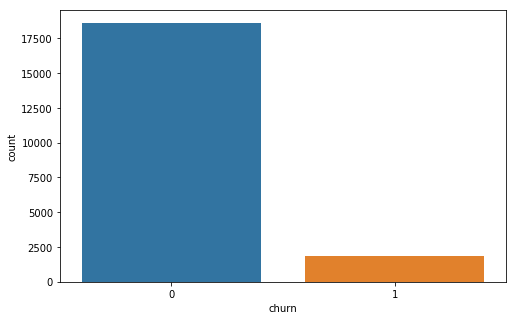

In [56]:
#Посмотрим на распределение целевого признака 
sns.countplot(df['churn']);

In [57]:
df['churn'].value_counts(normalize=True)

0    0.90898
1    0.09102
Name: churn, dtype: float64

**Вывод:** Видим, что переменная целевого признака распределена неравномерно. Одного класса больше чем другого, таким образом <br> выборка несбалансированна. Соотношение между классами (90.8% / 9.1%). <br>

Соотвественно:
* 90,8% - клиентов остаются.<br>
* 9,1% - попадают в отток.

In [58]:
# Посмотрим на статистические характеристики:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,20468.0,4.533433e+01,1.962458e+01,12.0,2.800000e+01,4.500000e+01,6.200000e+01,7.900000e+01
annualincome,20468.0,1.244468e+05,7.212939e+04,4.0,6.189800e+04,1.236895e+05,1.870652e+05,2.499870e+05
calldroprate,20468.0,3.502150e-02,2.299601e-02,0.0,1.000000e-02,4.000000e-02,6.000000e-02,7.000000e-02
callfailurerate,20468.0,1.523891e-02,1.121297e-02,0.0,1.000000e-02,2.000000e-02,3.000000e-02,3.000000e-02
callingnum,20468.0,4.220203e+09,3.365196e+08,102295480.0,4.251031e+09,4.251054e+09,4.251077e+09,4.251100e+09
customerid,20468.0,4.757953e+03,2.751070e+03,1.0,2.372750e+03,4.754000e+03,7.141250e+03,9.525000e+03
monthlybilledamount,20468.0,5.963025e+01,3.465268e+01,0.0,2.900000e+01,6.000000e+01,9.000000e+01,1.190000e+02
numberofcomplaints,20468.0,1.499169e+00,1.119153e+00,0.0,0.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
numberofmonthunpaid,20468.0,3.489252e+00,2.289740e+00,0.0,1.000000e+00,3.000000e+00,5.000000e+00,7.000000e+00
numdayscontractequipmentplanexpiring,20468.0,4.936682e+01,2.887414e+01,0.0,2.400000e+01,4.900000e+01,7.400000e+01,9.900000e+01


**Вывод**: 
* Из таблице, как это уже и описывалось выше, видно что  "year" является константой, его можно удалить из исследуемого датасета. <br> 
 Также из датасета можно удалить категориальный признак "noadditionallines", тк он принимает тоже единственное значение. <br> 
 Удалить признаки можно, потому что они не вносит никакой вклад в исследование, а также в дальнейшее обучение модели. 
* Статистики несильно скошены, тк среднее несильно больше медианы. Также максимальные значения несильно больше средних, таким образом выбросов у нас нет


In [59]:
# Удаляем 'year' и 'noadditionallines'
df.drop(['year','noadditionallines'], axis=1,inplace=True)

Посмотрим сколько у нас "отточных" клиентов ежемесячно.

In [60]:
churn=pd.crosstab(index=df['month'],columns=df['churn'])
churn['%']=round(churn[1]/churn[0]*100,2)

In [61]:
churn.T

month,1,2,3
churn,,,
0,8619.00,8609.00,1377.00
1,856.00,857.00,150.00
%,9.93,9.95,10.89


**Вывод:** Видна некоторая сезонность, к 3 месяцу отток клиентов возрастает.

Посмотрим на нашу целевую переменную в зависимости от других числовых показателей

In [62]:
оther=pd.pivot_table(data=df,values=df.iloc[:],columns=df['churn'],aggfunc=np.sum)
оther['%_churn']=оther[1]/оther[0]*100
оther.sort_values(by='%_churn',ascending=False).head(20)

churn,0,1,%_churn
numberofcomplaints,2.753200e+04,3.153000e+03,11.452128
unpaidbalance,2.336781e+06,2.556320e+05,10.939493
monthlybilledamount,1.107413e+06,1.130990e+05,10.212902
calldroprate,6.506400e+02,6.618000e+01,10.171523
numberofmonthunpaid,6.484700e+04,6.571000e+03,10.133082
callfailurerate,2.832900e+02,2.862000e+01,10.102722
totalminsusedinlastmonth,4.643204e+06,4.684850e+05,10.089692
month,2.996800e+04,3.020000e+03,10.077416
customerid,8.848222e+07,8.903565e+06,10.062547
avgcallduration,1.342640e+07,1.341695e+06,9.992963


**Вывод:** Видим зависит между churn и numberofcomplaints(количеством жалоб в сервисный центр) и unpaidbalance(неоплаченным балансом). Далее убедимся в этом на графике.

Посмотрим на нечисловые признаки.

In [63]:
# Посмотрим на нашу переменную в зависимости от штата проживания
df.groupby(['state'])['churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

state,SC,CA,IA,KY,OK,AR,NY,ND,UT,WV,...,IN,IL,VA,MN,MD,NJ,LA,AL,NE,VT
mean,0.158416,0.140312,0.126794,0.113333,0.112903,0.109792,0.108974,0.107728,0.105882,0.105413,...,0.07565,0.074271,0.07371,0.068736,0.06823,0.05305,0.0525,0.050898,0.048518,0.034853


**Вывод:** В некоторых штатх процент оттока больше, чем в других, 
причем разница между минимальным и максимальным значениями большая.
Видимо это связано с уровнем жизни, а также в крупных штатах больше компаний, следовательно больше выбор.

In [64]:
df.groupby(['gender'])['churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

gender,Female,Male
mean,0.09261,0.089354


In [65]:
df.groupby(['homeowner'])['churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

homeowner,No,Yes
mean,0.094912,0.090049


**Вывод:** Видим, что женщины в среднем меняют тариф чаще мужчин, а также те, кто не владеет домом. Последнее можно объяснить переездом.

In [66]:
df.groupby(['occupation'])['churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

occupation,Non-technology Related Job,Others,Technology Related Job
mean,0.098724,0.088778,0.086207


In [67]:
df.groupby(['education'])['churn'].agg([np.mean]).sort_values(by='mean', ascending=False).T

education,PhD or equivalent,Bachelor or equivalent,High School or below,Master or equivalent
mean,0.102564,0.097589,0.091416,0.072927


**Вывод:** Видим, что технологические люди уходят реже, видимо это связано с чуть бОльшей зарплатой в среднем. 
    Также видно, кто обладает степенью PhD уходит чаще, возможно это связано с перездом на место исследований.
    Также часто уходят школьники и бакалавры, видимо это связано с бОльшей мобильностью.

# 3. Первичный визуальный анализ признаков

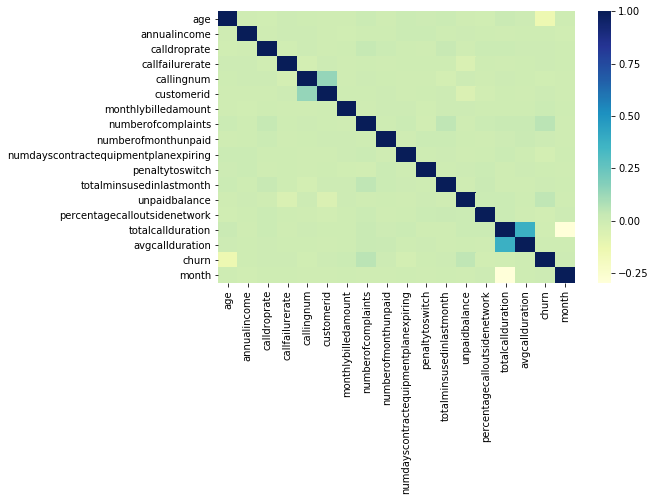

In [68]:
#Построим матрицу корреляции
plt.figure(figsize=(8,5))
corr_matrix=df.corr()
sns.heatmap(corr_matrix, cmap='YlGnBu');

**Вывод**:<br>
Видна зависимость между
* churn, numberofcomplaints и unpaidbalance, как это было видно из числового анализа выше.
* customerid и callingnum. Это логично, клиент и номер телефона тесно связаны.
* totalcallduration и avgcallduration. 

Для последней пары один из признаков, возможно, является избыточным, при обучении модели попробуем в дальнейшем удалить его для повышения качества модели.



Рассмотрим более детально признаки от которых зависит churn

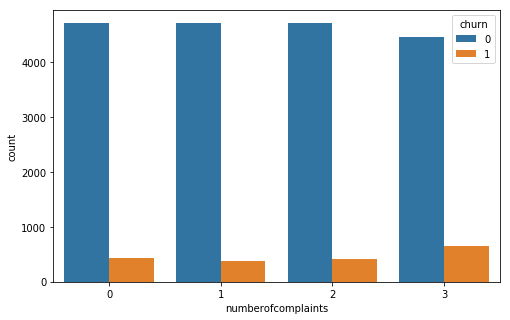

In [69]:
sns.countplot(x='numberofcomplaints', hue="churn", data=df);

**Вывод:** После третьего обращения в службу жалоб churn возрастает

In [70]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=3, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.add_legend()
    pyplot.show()

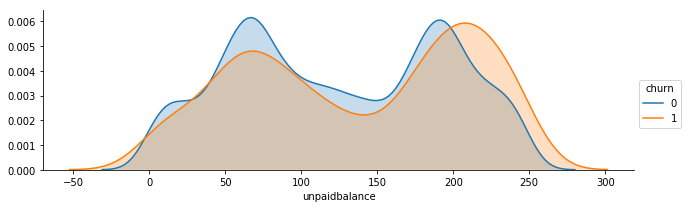

In [71]:
plot_distribution(df, 'unpaidbalance', 'churn')

**Вывод**: Видим, что при задолжности более 210 на балансе, пользователь скорее всего уйдет.<br>



Построим графики распределения признаков, вдруг найдем какие-нибудь инсайты.

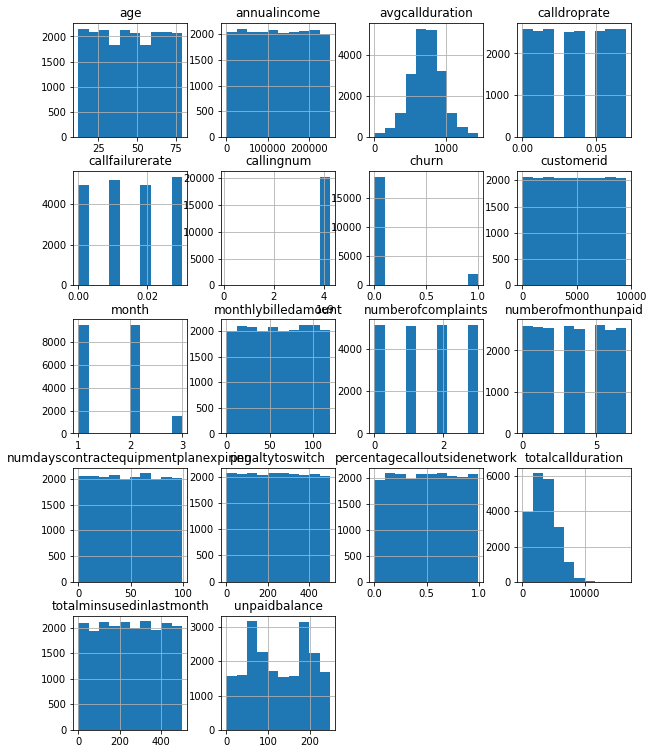

In [72]:
# Строим графики распределения признаков
plots = df.hist(figsize=(10,13))

**Вывод:** Аномалий или особенностей в графиках не замечено.

Посмотрим на бинарные и категориальные признаки.

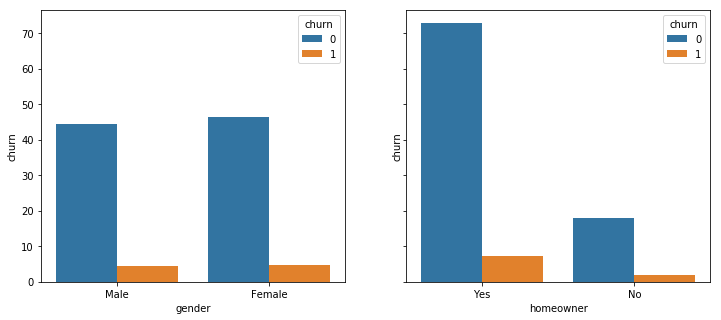

In [73]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))

sns.barplot(x="gender", y="churn", hue='churn', data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axes[0]);
sns.barplot(x="homeowner", y="churn", hue='churn', data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axes[1]);

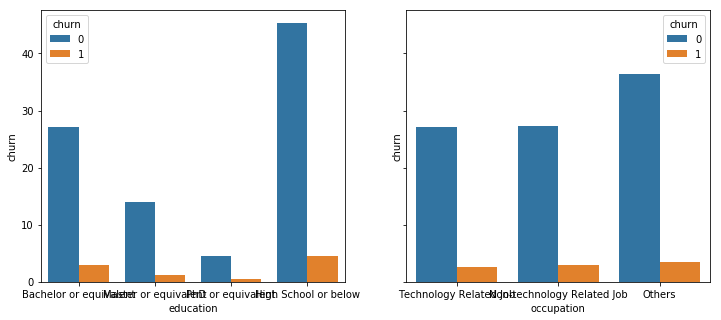

In [74]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))

sns.barplot(x="education", y="churn", hue='churn', data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axes[0]);
sns.barplot(x="occupation", y="churn", hue='churn', data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axes[1]);

Последние две диаграмы, а также анализ этих характеристик выше натолкнули на мысль построить еще пару графиков.<br>
Зависимость оттока от возраста и годового дохода.

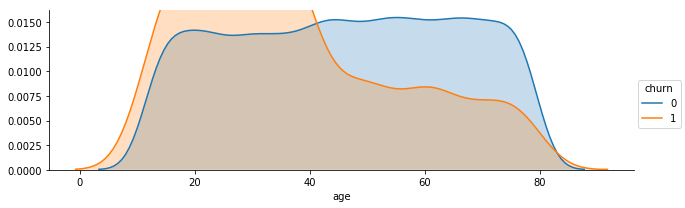

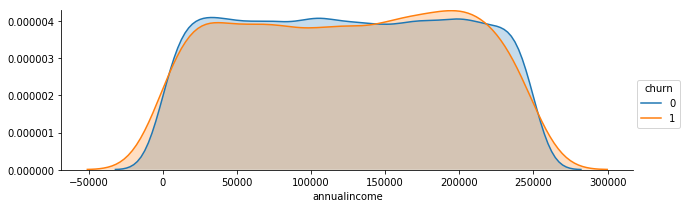

In [75]:
# Построим зависимость churn от возраста и годового дохода
plot_distribution(df, 'age', 'churn')
plot_distribution(df, 'annualincome', 'churn')

**Вывод:**  Видим, что к уходу склонны абоненты в возрасте от 20 до 40лет, а также пользователи с большим годовым доходом, начиная от 150.000. Первое объясняется бОльшей мобильность и интересом попробовать новое.

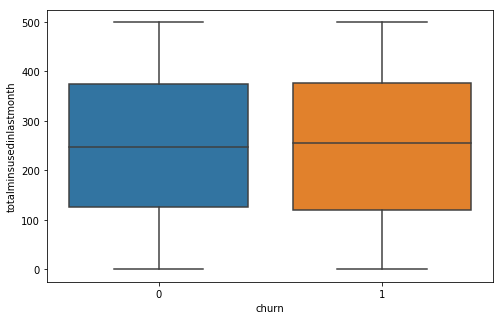

In [76]:
sns.boxplot(x='churn', y='totalminsusedinlastmonth', data=df);

**Вывод:**  Удивительно те, кто попал в отток в среднем использовали связь в прошлом месяце чуть-чуть больше. <br>
Возможно это конечно погрешность, тк разница небольшая, но в то же время для тех пользователь, 
кто потенциально может уйти<br> компания может сделать тариф чуть подешелве, тем самым увеличи лояльность абонента, и скорее всего останется.

Посмотрим еще на некоторые закономерности, которе удалось найти.

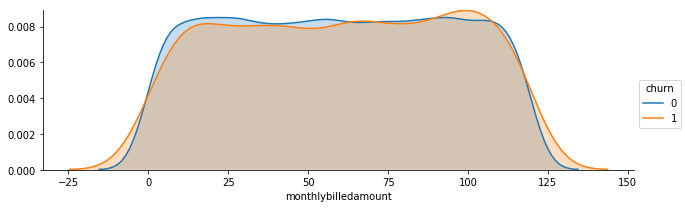

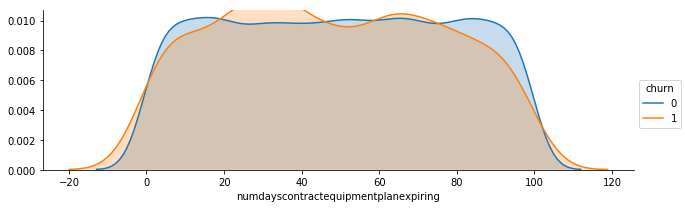

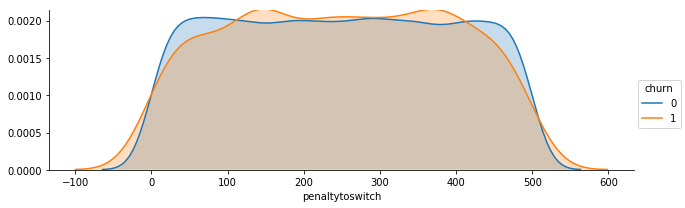

In [77]:
plot_distribution(df, 'monthlybilledamount', 'churn')
plot_distribution(df, 'numdayscontractequipmentplanexpiring', 'churn')
plot_distribution(df, 'penaltytoswitch', 'churn')

**Выводы:**
* При monthlybilledamount в окрестности 110, пользователь склонен к уходу, а также при значении более 115
* При numdayscontractequipmentplanexpiring в окрестности 30 абонент наиболее склонен к уходу
* При penaltytoswitch более 100 абонент начинает быть более склонен к уходу. 



# 4. Закономерности, "инсайты", особенности данных.

Найдены и выдвинуты предположения о природе различных закономерностей, найденных в предыдущих пунктах.<br>
Также важно заметить то, что наша целевая переменная распределена неравномерно.<br> 
Это нужно будет учесть при выборе метрики.<br>

**По проведённому анализу можно сделать выводы:**<br>
* Сильная зависит между оттоком и numberofcomplaints (количеством жалоб в сервисный центр) и unpaidbalance (неоплаченным балансом).  
    *  После третьего обращения в службу жалоб отток резко возрастает. <br>
    *  Также при задолжности на балансе более 210, пользователь скорее всего уйдет.
* Наблюдается некоторая сезонность, к 3 месяцу отток клиентов увеличивается.
* К уходу склонны абоненты в возрасте от 20 до 40лет, а также пользователи с большим годовым доходом, начиная от 150.000. 
    * Из возраста следует,также на это показали данные: школьники и бакалавры склонны к уходу больше и
    * Пользователи со степенью PhD, видимо из-за хорошей зарплаты, либо переезда на место исследований.
* Также часто попадают в отток те, кто не владеет недвижимостью, предположительно из-за переездов.
* В некоторых штатах процент оттока больше, чем в других, причем разница между ними существенная.  

**Все эти исследования были важны, тк**: 
* Теперь мы можем представить портрет пользователя, который скорее всего уйдет от нас.
* Использовать эти данные, как новые признаки для обучения модели.


# 5. Выбор метрики и ее обоснование


Для задач бинарной классификации обычно используются следующие метрики:<br>

* Доля правильных ответов(Accuracy)<br>
* Полнота(Recall)<br>
* Точность (Precision)<br>
* Среднее гармоническое Recall и Precision (F1-Score)<br>
* LogLoss<br>
* Площадь по ROC-кривой (ROC-AUC)<br>

В данной задаче целевой класс несбалансирован (90.8% / 9.1%).<br>
Также для применения модели в жизни нужно оценивать вероятность того, что клиент уйдет, чтобы выбрать оптимальный порог принятия решения на кого воздействовать различными способами. 
Таким образом, наиболее подходящей метрикой является ROC-AUC.

# 6. Предобработка данных

Когда просматривалась информация по конкретным customerid, был замечен такой интересный факт, что информация везде совпадает
кроме колонок totalcallduration и avgcallduration. 
Таким образом получается, что в данных может не быть временной зависимость для каждого абонента, например ситуации, когда
пользователь первый два месяца не находится в оттоке,а в последний месяц попадает в отток.<br>


In [78]:
df[df['customerid']==10].T

,19,20,21
age,23,23,23
annualincome,214765,214765,214765
calldroprate,0.06,0.06,0.06
callfailurerate,0.01,0.01,0.01
callingnum,4251042084,4251042084,4251042084
customerid,10,10,10
customersuspended,Yes,Yes,Yes
education,Bachelor or equivalent,Bachelor or equivalent,Bachelor or equivalent
gender,Male,Male,Male
homeowner,Yes,Yes,Yes


Попробуем строго доказать или опровергунть эту гипотезу.<br>
Для этого удалим колонки totalcallduration и avgcallduration, а также month и пройдемся по всем id пользователей и узнаем <br> есть для какого-то id две разные записи.

In [83]:
%%time
def CheckTimeDependence(df):
    # Скопировали DataFrame
    df2= df.copy(deep=True)

    # Удалим колонки totalcallduration и avgcallduration, month
    df2.drop(['totalcallduration', 'avgcallduration', 'month'], axis=1, inplace=True)

    # Удалим дубликаты
    df2.drop_duplicates(inplace=True)
    
    # Цикл, проверяющий наличие более 2х записей для абонента
    for customer_id in df2['customerid'].values:
        if ((df2[df2['customerid']==customer_id].shape[0])==1):
            continue
        else:
            print('Есть временная зависимость')
            print('Временная зависимость присуствует для id', customer_id)
            break 
    print('Временной зависимости нет')
    
CheckTimeDependence(df)

Временной зависимости нет
CPU times: user 20.4 s, sys: 140 ms, total: 20.5 s
Wall time: 20.4 s


**Вывод:** Временной зависимость в разрезе конкретного абонента нет, таким образом для дальнейшего обучения, <br>
    можем агрегировать данные по абонентам.

In [84]:
categorical_df = df.loc[:, (df.dtypes == object)].assign(customerid = df['customerid'])
categorical_df.drop_duplicates(inplace=True)

In [85]:
df = df.groupby(['customerid'], as_index=False).agg([np.mean])
df.columns = df.columns.droplevel(1)
df = df.join(categorical_df.set_index('customerid'), on='customerid')

Так как в нашей задаче есть бинарные и категориальные признаки предобработаем их, чтобы превратить в числовые.

In [86]:
def features_extract(df):
    # Преобразуем все категориальные данные в числовые
    d = {'Yes': 1, 'No': 0, 'Male':1, 'Female':0 , 'Single':1,'Married':0  }

    df['customersuspended'] = df['customersuspended'].map(d)
    df['usesinternetservice'] = df['usesinternetservice'].map(d)
    df['usesvoiceservice'] = df['usesvoiceservice'].map(d)
    df['gender'] = df['gender'].map(d)
    df['homeowner'] = df['homeowner'].map(d)
    df['maritalstatus'] = df['maritalstatus'].map(d)

    # Делаем get_dummies для категориальных признаков 
    education = pd.get_dummies(df['education'])
    occupation = pd.get_dummies(df['occupation'])
    state = pd.get_dummies(df['state'])

    df = pd.concat([df, education, occupation, state], axis=1)


    # Удалим пару неинформативных столбцов, тк по ним сделали get_dummies, 
    # а также столбец month, тк временной зависимости в данных нет
    df.drop(['education','occupation','state', 'month'], axis=1,inplace=True)
    
    return df

df = features_extract(df)

# 7. Выбор модели и baseline

### 7.1 Выбор модели
В качестве моделей будут использоваться:

* Логистическую регрессию(LogisticRegression)
* Случайный лес(RandomForestClassifier)
* Градиентный бустинг над деревьями 

В принципе, это наиболее часто используемые модели для задач классификаций, где обучающая выборка не очень большая и не сильно разряженная. У каждой модели есть свои плюсы для решаемой задачи:

* Логистическая регрессия хороша тем, что легко можно запустить в production, есть интепритируемость;
* Случайный лес - даёт хорошее качество без настройки гиперпараметров, не склонен к переобучению;
* Градиентный бустинг - возможность получить лучшее качество при настройки гиперпараметров. 

### 7.2  Baseline для модели.

In [88]:
y = df['churn']
X = df.drop(['churn'], axis=1) 

In [89]:
#Разбиение выборки на train и test, первый 'baseline'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y ,random_state=42)

In [90]:
np.random.seed(42)

# Pipeline для Dummy модели, хотя можно было обойтись и без pipeline
clf = Pipeline([('std', StandardScaler()),
                ('clf', DummyClassifier(strategy='stratified'))]) 

np.mean(cross_val_score(clf,X_train,y_train,cv=5,scoring='roc_auc'))

0.5001854692701527

**Вывод:** Ожидаемый результат: ROC-AUC 50%. <br>
Мы просто предсказываем вероятность ухода клиента согласно распределению наших классов, <br>
те с вероятностью  90,8% клиент останется, а с 9,1% уйдет.<br>
Это наш baseline. 


# 8. Кросс-валидация и настройка гиперпараметров модели

Посмотрим на результаты классификаторов без добавление новых признаков

In [91]:
classifiers = [LogisticRegression(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(), 
               RandomForestClassifier()] 
#               SVC()] # 
classifiers_name = ['LogisticRegression',
                    'KNeighborsClassifier',
                    'GradientBoostingClassifier', 
                    'RandomForestClassifier'] 
#                    'SVC']


In [92]:
# Настройка параметров выбранных алгоритмов с помощью GridSearchCV 
n_folds = 5
scores = []
fits = []
logistic_params = {'clf__penalty': ('l1', 'l2'),
                   'clf__C': (.01,.1,1,5)}
knn_params = {'clf__n_neighbors': list(range(3, 12, 2))}
gbm_params = {'clf__n_estimators': [100, 300, 500],
              'clf__learning_rate':(0.1, 0.5, 1),
              'clf__max_depth': list(range(3, 6)), 
              'clf__min_samples_leaf': list(range(10, 31, 10))}
forest_params = {'clf__n_estimators': [100, 300, 500],
                 'clf__criterion': ('gini', 'entropy'), 
                 'clf__max_depth': list(range(3, 6)), 
                 'clf__min_samples_leaf': list(range(10, 31, 10))}

#svm_param = {'kernel' : ('linear', 'rbf'), 'C': (.5, 1, 2)} - очень долго считал
params = [logistic_params, knn_params, gbm_params, forest_params]

In [14]:
%%time
np.random.seed(42)

for i, each_classifier in enumerate(classifiers):
    clf = each_classifier
    clf_params = params[i]
    clf = Pipeline([('std', StandardScaler()),
                    ('clf', clf)])  
    grid = GridSearchCV(clf, clf_params, 
                        cv=5, 
                        n_jobs=-1, scoring="roc_auc")
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    scores.append(clf_best_score)
    print(classifiers_name[i], clf_best_score, "\n", grid.best_params_, "\n")

LogisticRegression 0.6449871767377392 
 {'clf__C': 0.1, 'clf__penalty': 'l1'} 

KNeighborsClassifier 0.5133641695104244 
 {'clf__n_neighbors': 3} 

GradientBoostingClassifier 0.7011281414164963 
 {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 100} 

RandomForestClassifier 0.7074815527744652 
 {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 30, 'clf__n_estimators': 100} 

CPU times: user 20.8 s, sys: 2.76 s, total: 23.5 s
Wall time: 42min


**Вывод:** Наша модель уже улучшила baseline.  Теперь попробуем добавить новые признаки и еще улучшить метрику.<br>
Пронаблюдаем за поведением двух моделей, RandomForestClassifier и GradientBoostingClassifier тк результаты у них очень схожи.

# 9. Создание новых признаков и описание этого процесса 

In [93]:
%%time

#По честному еще раз считываем данные
df = pd.read_csv('telco-customer-churn.csv')

# Удаляем 'year' и 'noadditionallines'
df.drop(['year','noadditionallines'], axis=1,inplace=True)

CPU times: user 188 ms, sys: 12.1 ms, total: 200 ms
Wall time: 204 ms


In [94]:
# Выделяем категориальные признаки 
categorical_df = df.loc[:, (df.dtypes == object)].assign(customerid = df['customerid'])
categorical_df.drop_duplicates(inplace=True)

# Агрегируем информацию
df = df.groupby(['customerid'], as_index=False).agg([np.mean])
df.columns = df.columns.droplevel(1)
df = df.join(categorical_df.set_index('customerid'), on='customerid')

**Новые признаки:**
* Целевая услуга мобильной связи - это звонки, поэтому создадим новый признак "стоимость минуты звонка".
* Выделим в отдельную переменную штаты, в которых наибольших процент оттока.
* Выделим отдельно интервал возраста, когда пользователи уходят.
* Тк totalcallduration и avgcallduration зависимы удалим первый.

In [95]:
# Стоимость минуты разговора 
df['costofminute'] = (df['monthlybilledamount'] / df['totalminsusedinlastmonth']).round(2)

# Выделим в отдельную переменную штаты,в которых наибольших процент оттока
df2 = df.groupby(['state'])['churn'].agg([np.mean]).sort_values(by='mean', ascending=False)
# штаты, в которых наибольший отток 
state = df2[df2['mean']>0.10].index.values
df['state_most_churn'] = df['state'].map(lambda x: 1 if x in state else 0)

# Выделим отдельно интервал возраста, когда пользователи уходят
df['age_most_churn'] = df['age'].map(lambda x: 1 if  20<=x<=30 else 0 )

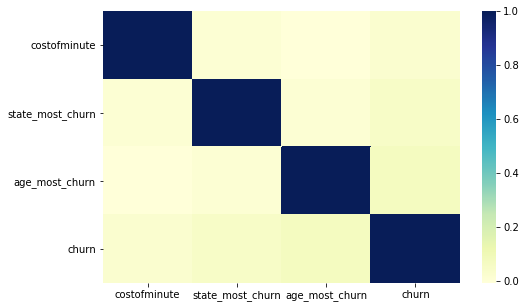

In [96]:
#Построим матрицу корреляции
plt.figure(figsize=(8,5))
corr_matrix=df[['costofminute', 'state_most_churn', 'age_most_churn' ,'churn']].corr()
sns.heatmap(corr_matrix, cmap='YlGnBu');

**Вывод:** Видим, что "стоимость минуты звонка" плохо коррелирует с целевой переменной, поэтому удалим ее, а другие признаки добавим в модель и посмотрим на результат.

In [97]:
# Преобрабатываем все категориальные признаки
df = features_extract(df)

In [98]:
df.drop(['totalcallduration','costofminute'], axis=1,inplace=True)

In [99]:
y = df['churn']
X = df.drop(['churn'], axis=1) 

In [100]:
#Разбиение выборки на train и test, первый 'baseline'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y, random_state=42)

In [101]:
%%time
np.random.seed(42)
grb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, min_samples_leaf = 10, n_estimators =100)
clf_grb = Pipeline([('std', StandardScaler()),
                    ('clf', grb)])  

# Замеряем результат модели
print(np.mean(cross_val_score(clf_grb,X_train,y_train,cv=5,scoring='roc_auc')))

0.707353915542195
CPU times: user 16.4 s, sys: 3.87 ms, total: 16.4 s
Wall time: 16.4 s


In [102]:
%%time
np.random.seed(42)
rfr = RandomForestClassifier(criterion = 'gini', max_depth = 3, min_samples_leaf = 30, n_estimators =100)
clf_rfr = Pipeline([('std', StandardScaler()),
                    ('clf', rfr)])  # Вообще для RandomForest можно не делать  StandardScaler
# Замеряем результат модели
print(np.mean(cross_val_score(clf_rfr,X_train,y_train,cv=3,scoring='roc_auc')))

0.7018968785360992
CPU times: user 2.54 s, sys: 3.98 ms, total: 2.54 s
Wall time: 2.54 s


**Вывод:** Добавление новых признаков улучшило модель GradientBoostingClassifier (предыдущий результат был 0.7011), <br>
но ухудшило RandomForestClassifier (предыдущий результат был 0.7074). Такой результат тоже неплохой. <br> 
Дальше стоит работать над перебором признаков.

Выведем фичи наиболее сильно оказавшие на результат модели.

In [103]:
# GradientBoostingClassifier

clf_grb.fit(X_train,y_train)
features = list(zip(grb.feature_importances_,X_train.columns))
sorted(features, key=lambda x: x[0], reverse=True)[:10]

[(0.11507048408265522, 'unpaidbalance'),
 (0.11370015427483855, 'age'),
 (0.09409072267745122, 'avgcallduration'),
 (0.08670034550662181, 'annualincome'),
 (0.08063264059658337, 'penaltytoswitch'),
 (0.07942553370177162, 'callingnum'),
 (0.07564782265332795, 'percentagecalloutsidenetwork'),
 (0.07307540243104507, 'totalminsusedinlastmonth'),
 (0.057545970255569755, 'monthlybilledamount'),
 (0.04824982945856348, 'numberofcomplaints')]

In [104]:
# RandomForestClassifier

clf_rfr.fit(X_train,y_train)
features = list(zip(rfr.feature_importances_,X_train.columns))
sorted(features, key=lambda x: x[0], reverse=True)[:10]

[(0.22314229333590166, 'age'),
 (0.15475490275628925, 'unpaidbalance'),
 (0.0886567732447171, 'age_most_churn'),
 (0.07622755356783376, 'numberofcomplaints'),
 (0.04971087477269862, 'callingnum'),
 (0.04630777333659315, 'percentagecalloutsidenetwork'),
 (0.041420731494471334, 'totalminsusedinlastmonth'),
 (0.03864527848424697, 'state_most_churn'),
 (0.03449434879221191, 'avgcallduration'),
 (0.030130320816290922, 'annualincome')]

**Вывод:** Видим, что созданные нами признаки вошли в топ-10, в RandomForestClassifier, находятся на 4 и 8 месте по значимости.

# 10. Построение кривых валидации и обучения

In [105]:
# Кривые обучения и валидации
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

CPU times: user 3min 6s, sys: 50.1 ms, total: 3min 6s
Wall time: 3min 6s


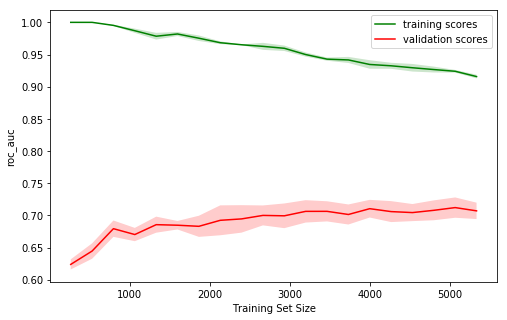

In [46]:
%%time
# Кривая обучения GradientBoostingClassifier
plot_learning_curve(clf_grb, X_train, y_train, scoring='roc_auc', cv=5)

**Вывод:** Кривая валидации GradientBoostingClassifier показывает, что увеличение количества данных, может привести к улучшению модели 

CPU times: user 5min 34s, sys: 251 ms, total: 5min 34s
Wall time: 5min 34s


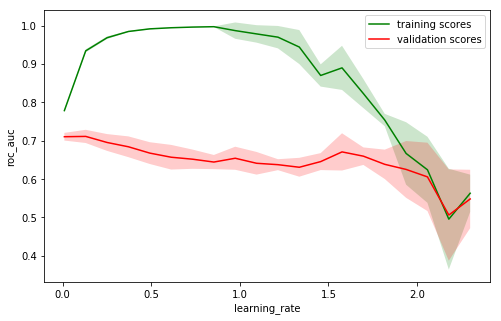

In [215]:
%%time
# Кривая валидации GradientBoostingClassifier
learning_rates = np.linspace(0.01, 2.3, 20)
plot_validation_curve(clf_grb, X_train, y_train, 
                    cv_param_name='learning_rate', 
                    cv_param_values=learning_rates,
                    scoring='roc_auc')

**Вывод** Выбрана довольно сложная модель, возможно стоит подумать над регуляризацией.

# 11. Прогноз для  отложенной выборки

In [106]:
# Обучаем модель
clf_grb.fit(X_train,y_train)
clf_rfr.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
           ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [107]:
# Делаем предсказание
y_pred_proba_grb = clf_grb.predict_proba(X_val)
y_pred_proba_rfr = clf_rfr.predict_proba(X_val)


In [108]:
print('ROC-AUC GradientBoostingClassifier: ', roc_auc_score(y_val,y_pred_proba_grb[:,1]))
print('ROC-AUC RandomForestClassifier : ', roc_auc_score(y_val,y_pred_proba_rfr[:,1]))      

ROC-AUC GradientBoostingClassifier:  0.7129740608228979
ROC-AUC RandomForestClassifier :  0.6931753130590339


**Вывод:** Результат получился почти такие же как и на валидации, значит мы валидировали наши модели правильно.<br>
При этом на тестовой выборке GradientBoostingClassifier показал результаты лучше, чем RandomForestClassifier, <br> вот почему ранее было принято решение рассматривать не одну, а две модели после подбора параметров.

# 12. Результаты работы

**Техническая задача:**<br>
По итогу была построена модель, предсказывающая отток абонентов. <br>
Полученное качество модели, оцененное с помощью метрики ROC-AUС составляет 0.71, что говорит о высокой предсказательной способности модели.

**Бизнес-задача:**<br>
Теперь для бизнеса есть модель, которая может предсказывать, отток клиентов.<br>

*Способы применения:*<br>
* 1) Предсказывать для конкретного абонента вероятность того, что он уйдет. Далее нужно провести еще математические исследования, чтобы понять начиная с какого порога, считать клиента ушедшим.
С точки зрения бизнеса, я бы сделал цепочку взаимодействия с пользователем, если его вероянсть уйти становится выше 50%. Например: если вероятность уйти составила бы 60% предложил бы бонус, если вероятность все равно ростет, то предложил бы еще более существенный бонус и тд... Те давал бы клиенту бонус не на последнем этапе, когда он хочет уходить, а разбил бы на небольшие интервал от 50% до 99%, и на каждом из них взаимодействовал бы с пользователем. 
* 2) При планировании бюджета. Отслеживание метрик бизнеса и планирование выручки на следующий месяц.

# 13. Что можно сделать еще

**Feature Engineering**<br>
Создать еще больше признаков, тк зачастую создание признаков намного важнее чем тюнинг модели.<br>
Например:
* mean target кодирование признаков, а также попарно перемножая существующие признаки и их кодирование тоже.<br>
При этом подходе нужно быть осторожным с валидацией, чтобы не было leak(ов).
* перебор признаков: выбор оптимального количества. Скорее всего здесь бы использовал жадный алгоритм. 

**Моделирование**
* Стоит еще раз попробовать LogisticRegression предварительно отшкалировав данные. И построив ее на новых признаках. Если удасться добиться качества сравнимого с алгоритмами бустинга, то логистическая регрессия является более перспектиным алгоритмом, тк легко внедряется в production.
* Так как "градиентный бустинг" показал себя хорошо. Стоит попробовать другие бустинг алгоритмы на тех же параметрах, <br> например (xgboost, lightgbm, catboost) и далее уже приступить к более тщательному тюнингу одного их них.
* Использовать blending моделей: усреднить показатели от всех моделей.
